# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import re

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.dummy import DummyClassifier
from spacy.lang.en import English

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm
import lightgbm as lgbm
from tqdm import tqdm
import nltk
import spacy
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from scipy.sparse import csr_matrix, hstack


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.sample(20)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
15293,tt0115195,tvMiniSeries,Gulliver's Travels,Gulliver's Travels,1996,1996,186,0,"Adventure,Drama,Family",6.9,6165,I remember when this NBC mini-series aired whe...,9,pos,1,test,6003
39012,tt0470420,movie,The Leap Years,The Leap Years,2008,\N,103,0,Romance,6.2,126,The Leap Years stars some heavy hitters in the...,1,neg,0,train,9163
7407,tt0084395,movie,Class Reunion,Class Reunion,1982,\N,84,0,"Comedy,Horror",4.8,1888,Personal taste rules when it comes to talking ...,10,pos,1,train,5447
42335,tt0351078,movie,The Threat,Hotet,2004,\N,103,0,"Action,Thriller",5.0,1443,I did not set very high expectations for this ...,7,pos,1,train,4651
9918,tt0090944,movie,Devil in the Flesh,Diavolo in corpo,1986,\N,114,0,"Drama,Romance",5.9,1344,Bellocchio refers to this as a mainly politica...,7,pos,1,train,12361
35309,tt0312528,movie,The Cat in the Hat,The Cat in the Hat,2003,\N,82,0,"Adventure,Comedy,Family",3.9,50252,"Holy cow, what a piece of sh*t this movie is. ...",1,neg,0,train,9453
33561,tt0367122,movie,Target,Target,2004,\N,84,0,"Action,Thriller",2.9,557,One of the worst movies I've ever seen. When I...,1,neg,0,test,7873
14579,tt0085603,movie,Going Berserk,Going Berserk,1983,\N,84,0,Comedy,5.3,1556,"yeah, it's a bit of a silly film, so if you ar...",10,pos,1,train,2416
26752,tt0486640,movie,Postal,Postal,2007,\N,100,0,"Action,Comedy,Crime",4.5,22063,I saw this movie at the Edmonton International...,1,neg,0,train,11634
44852,tt0153464,movie,Up at the Villa,Up at the Villa,2000,\N,115,0,"Drama,Romance",6.0,2545,Let me be clear. I hate these kinds of movies....,3,neg,0,test,12139


In [5]:
# looking at column info
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


> On first glance it does not look like certain columns in the dataframe need a type change. Let's look at missing values.

In [6]:
#Finding out sum & percentage of missing values in each feature.
print("======= Amount Missing =======")
missing_values_count = df_reviews.isnull().sum()
print(missing_values_count[0:10])
print("\n")
print("======= Percent Missing =======")
null = (df_reviews.isna().sum()/len(df_reviews)) * 100
print(null[null>0].sort_values())

======= Amount Missing =======
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
dtype: int64


======= Percent Missing =======
average_rating    0.004226
votes             0.004226
dtype: float64


> We have a small percent (<1%) of data missing. Dropping these will not have a major impact on the results. 

In [7]:
df_reviews.dropna(inplace=True)

In [8]:
df_reviews.loc[0,"review"]

"The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!"

> The first review in the review column!

## EDA

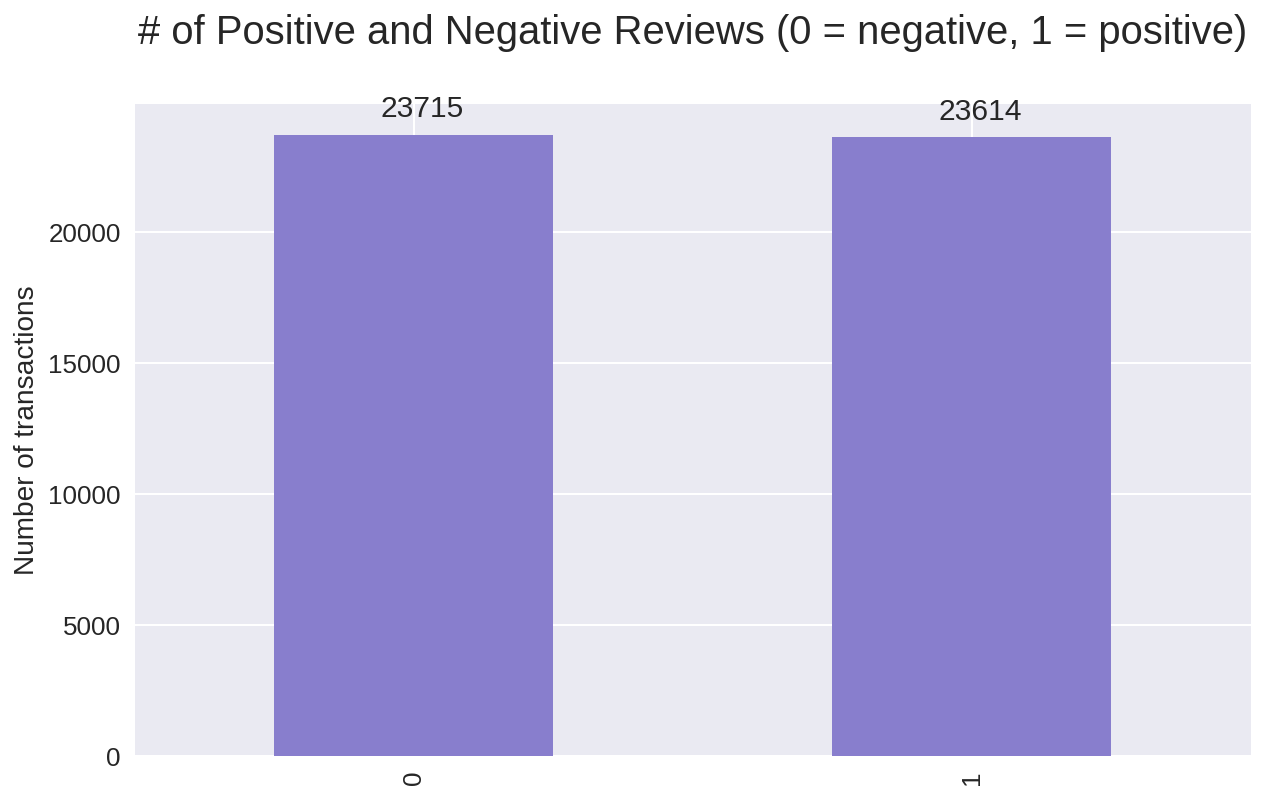

In [9]:
ax = df_reviews['pos'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#887ecd')
ax.set_title('# of Positive and Negative Reviews (0 = negative, 1 = positive)', size=20, pad=30)
ax.set_ylabel('Number of transactions', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

> No significant class imbalance exists. Let's continue ...

Let's check the number of movies and reviews over years.

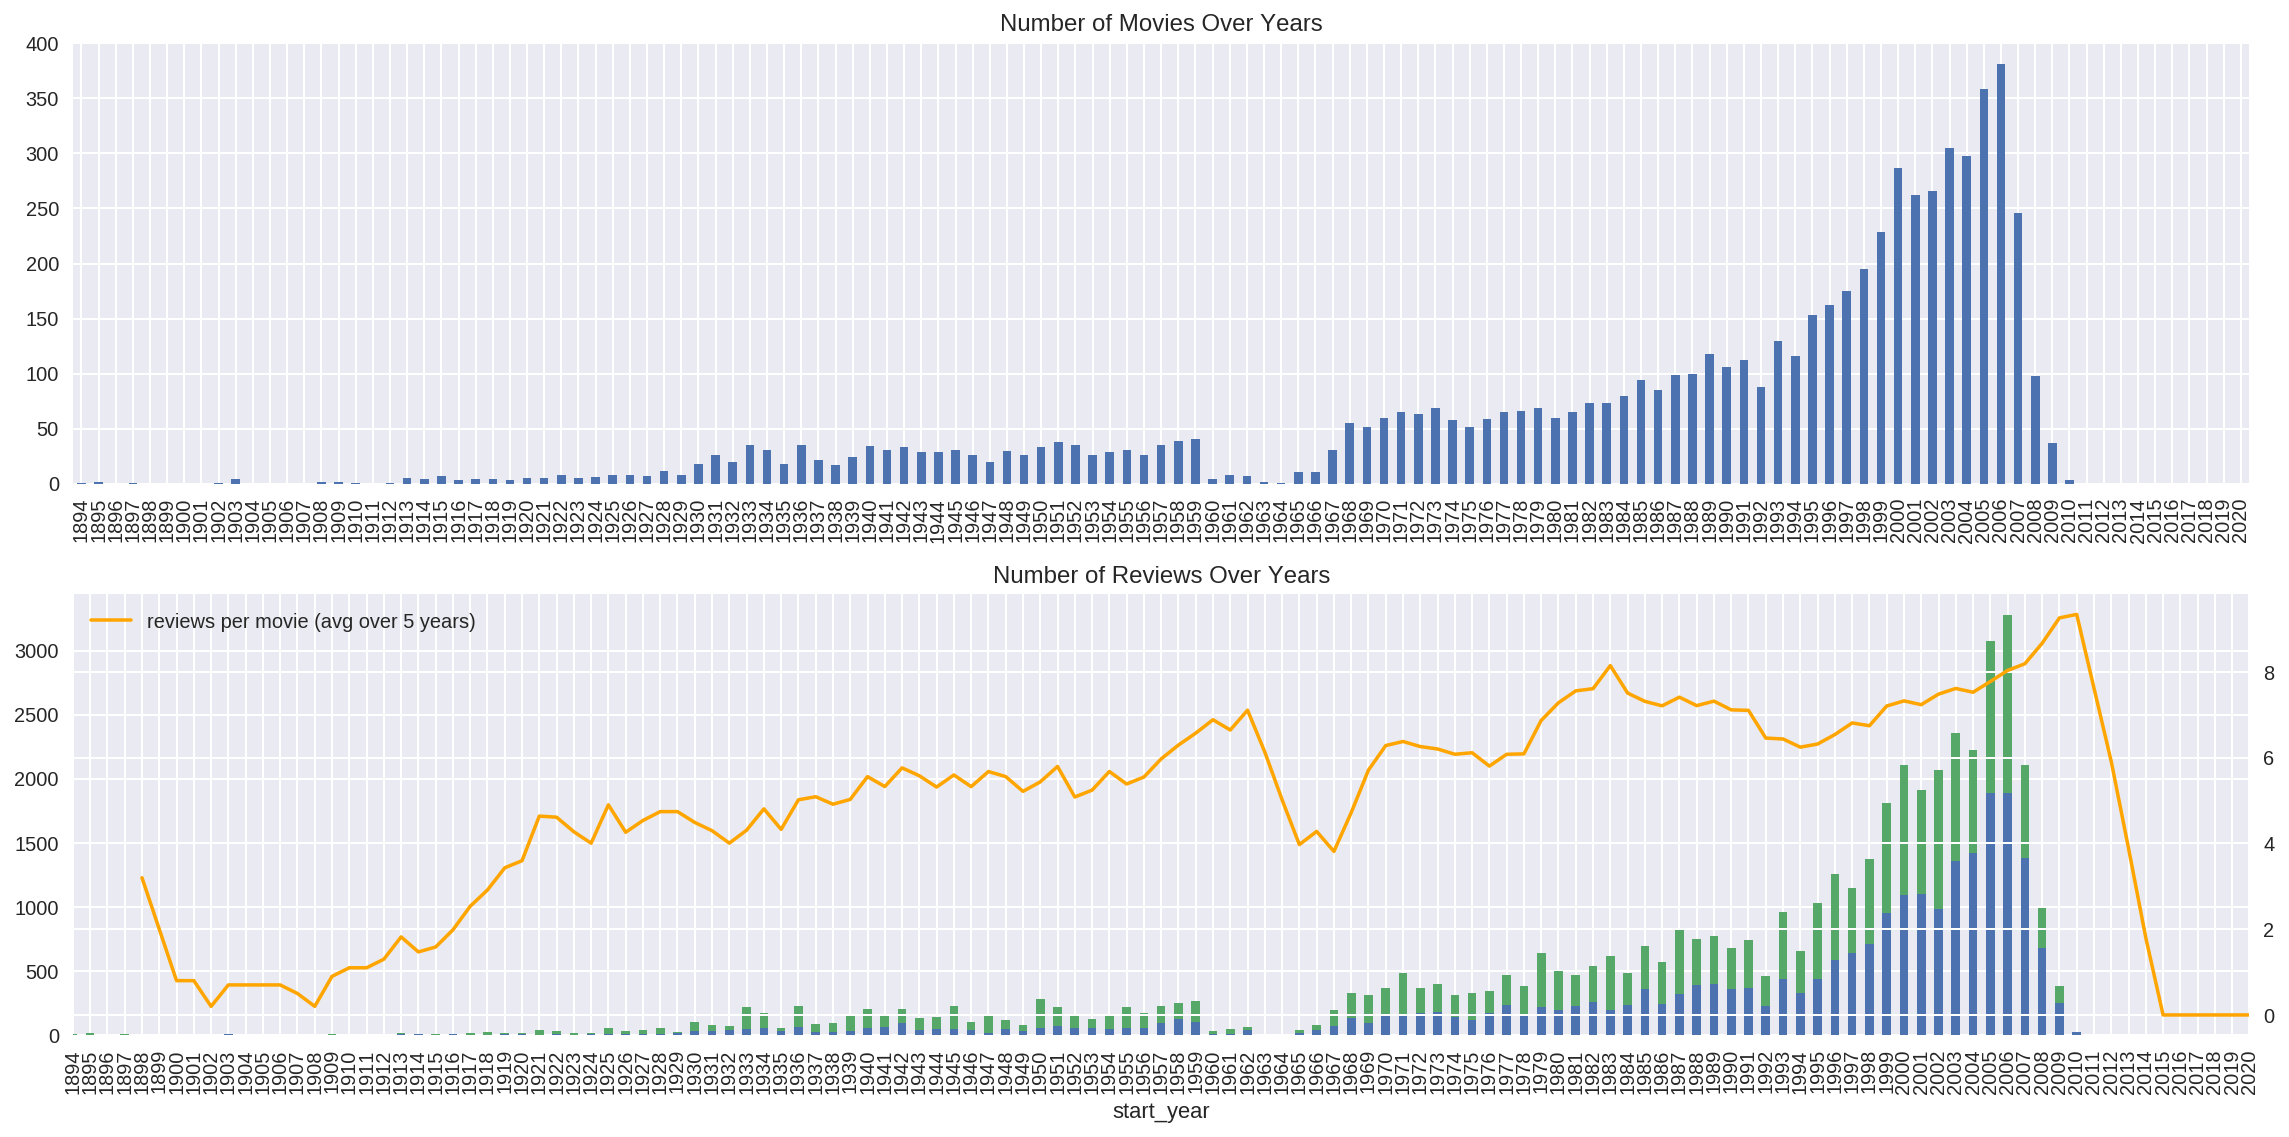

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

> As the number of movies released increased, so did the number of reviews. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

In [11]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

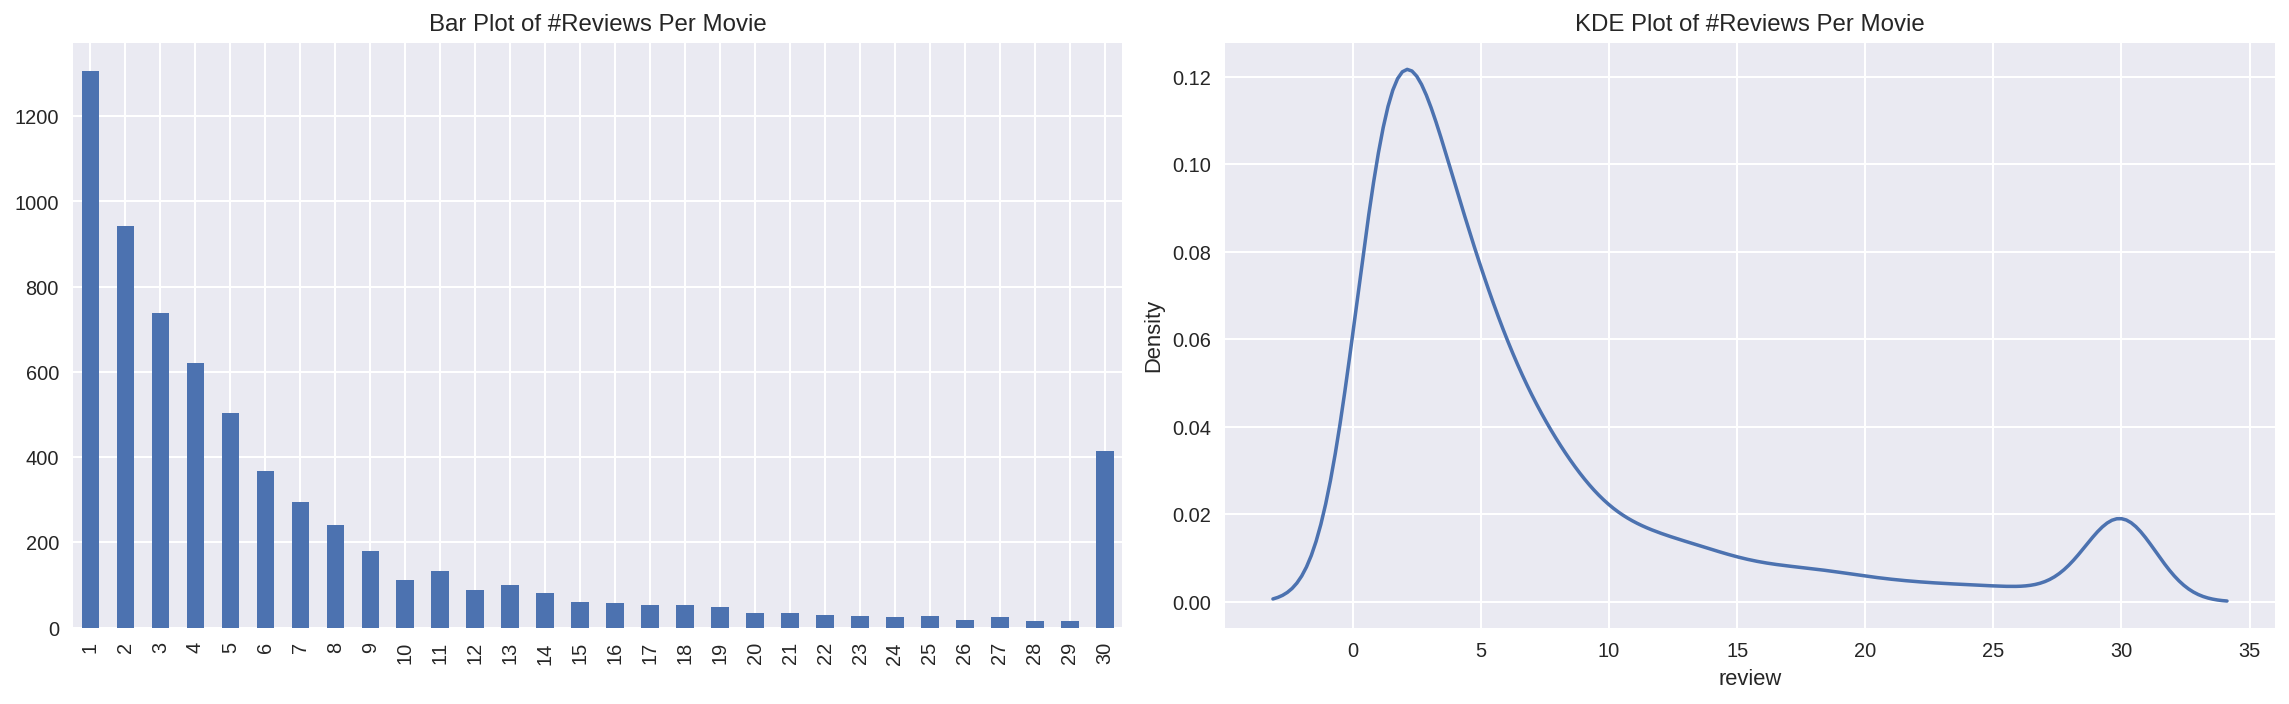

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

> Most movies have 1 review!

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

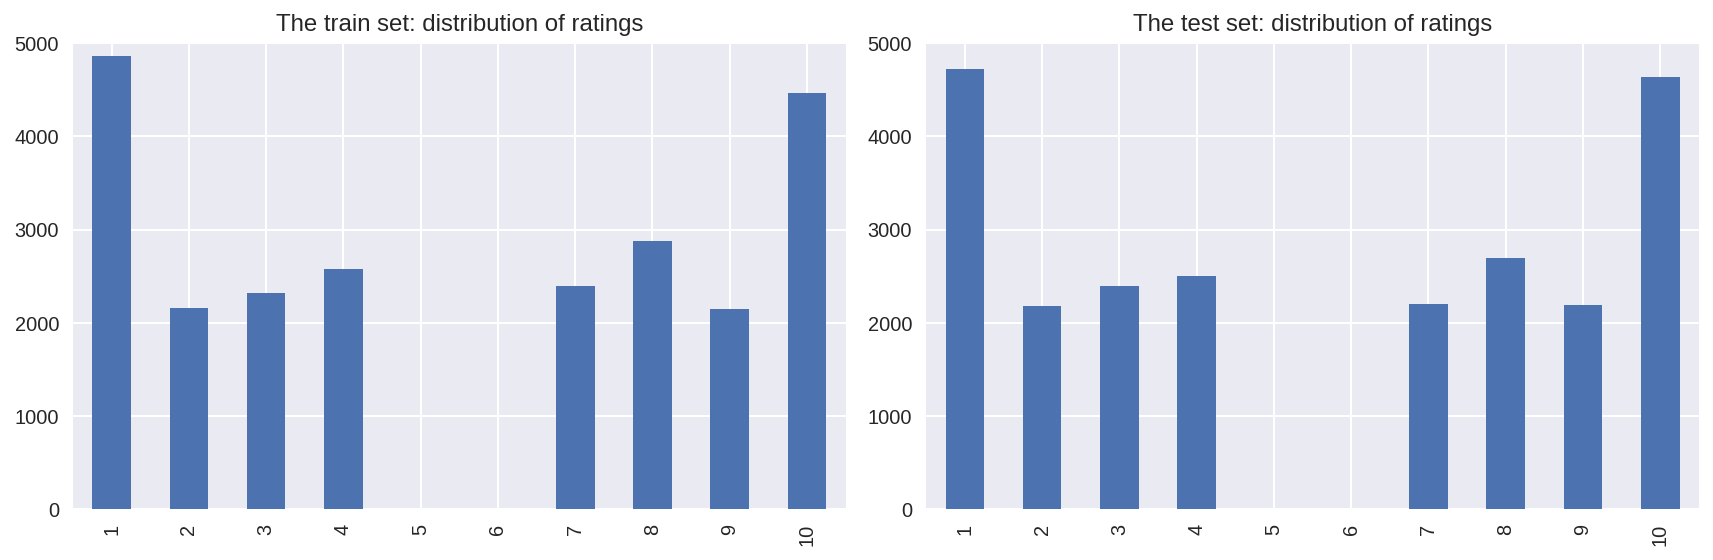

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

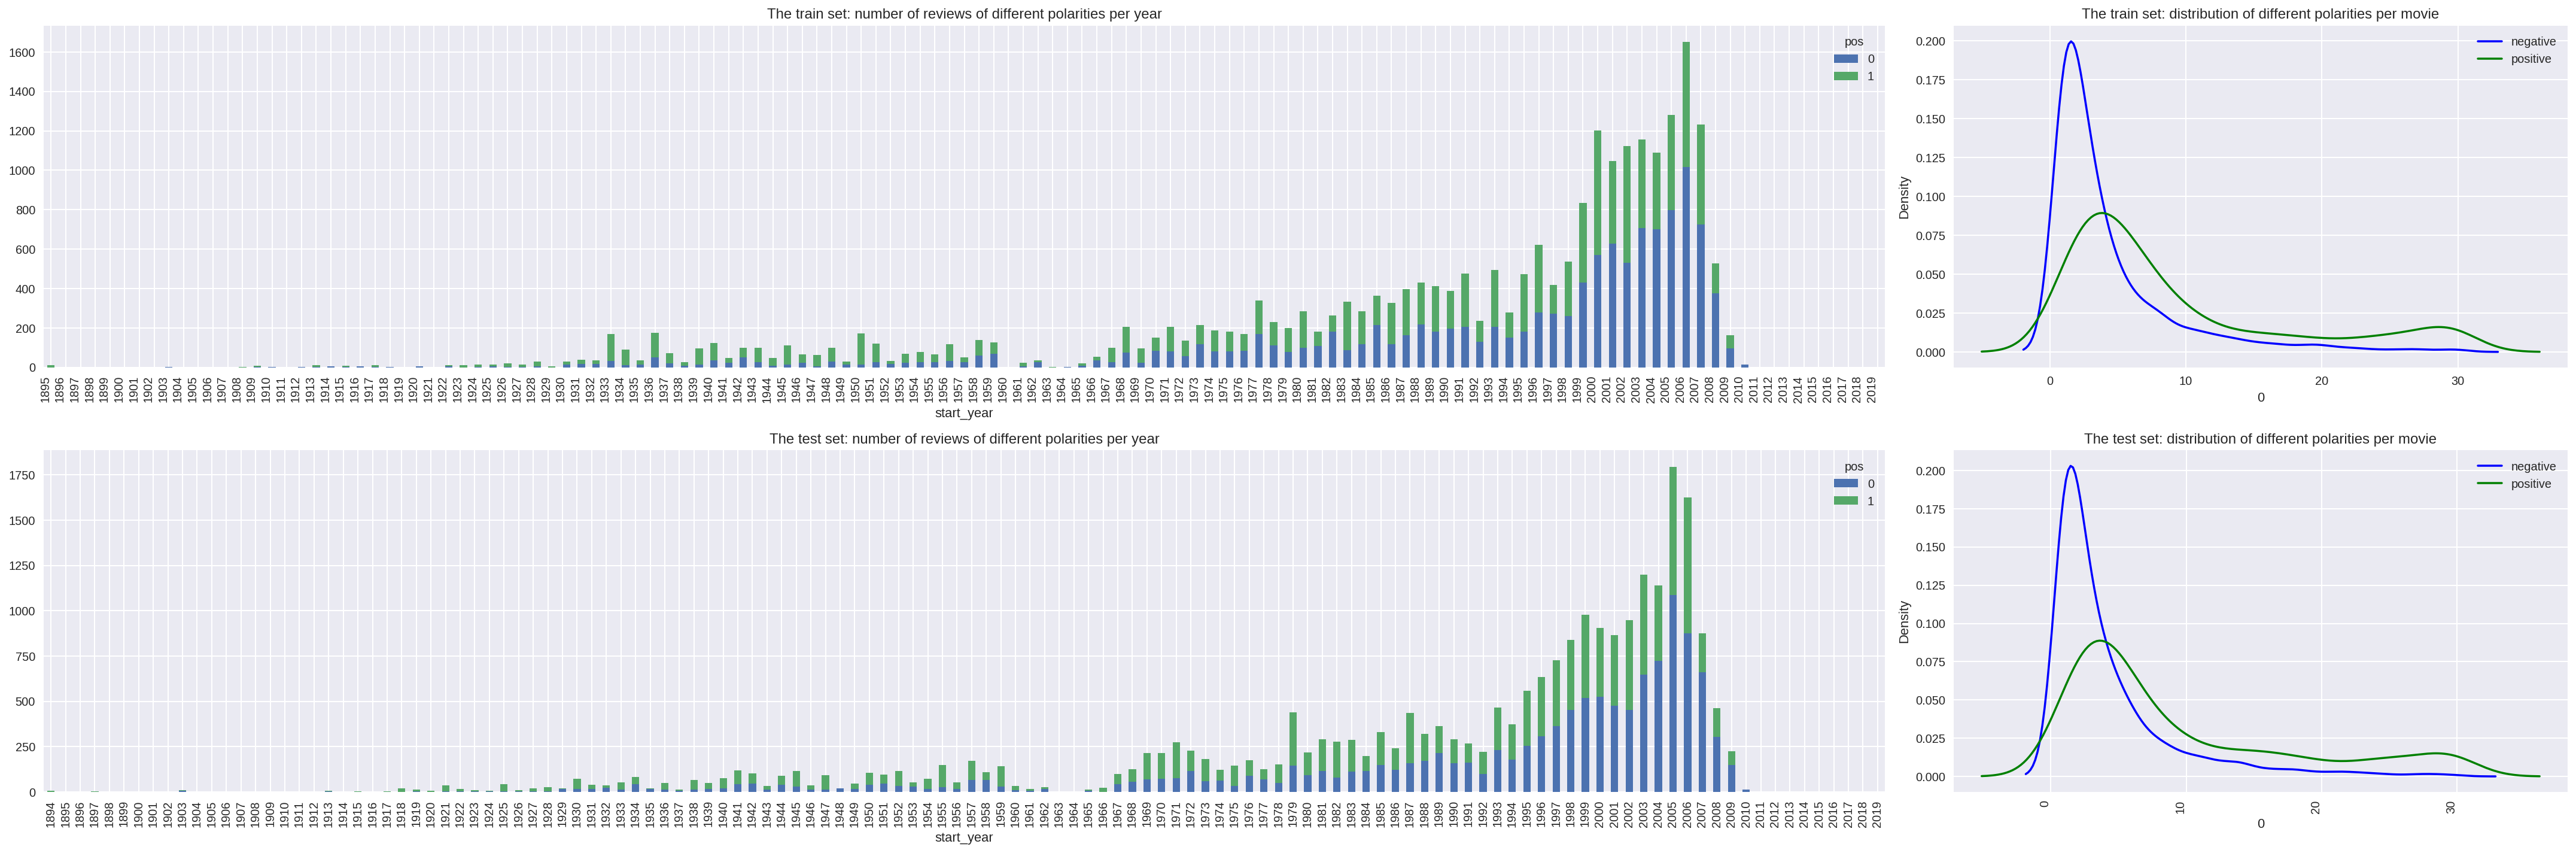

In [15]:
fig, axs = plt.subplots(2,2,figsize=(20, 10), gridspec_kw=dict(width_ratios=(3, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.gcf().set_size_inches(30, 10)
ax.set_title('The train set: number of reviews of different polarities per year')
ax = axs[0][1]


dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')
ax = axs[1][1]
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')


dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')


fig.tight_layout()

> As years passed, positive movie reviews greatly increased, but so did negative movie reviews. This increase could be caused by the creation of better movies!

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [1]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        
        if isinstance(pred_target[0],str):
            pred_target = [True if x=='True' else 'False' for x in pred_target]
        pred_proba = model.predict_proba(features)[:, 1]
        
     
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

    
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'


        # ROC
        ax = axs[0]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
     
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub(r"[^a-zA-Z']", ' ', x.lower()))

In [18]:
df_reviews.sample(15)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
4435,tt0071206,movie,Benji,Benji,1974,\N,86,0,"Adventure,Family,Romance",6.2,4283,You know the movie could have been a lot bette...,3,neg,0,test,3963,you know the movie could have been a lot bette...
6399,tt0439491,movie,Caribe,Caribe,2004,\N,90,0,"Drama,Mystery",6.0,220,This movie has to be one of the most boring an...,2,neg,0,test,866,this movie has to be one of the most boring an...
36964,tt0473356,movie,The Flock,The Flock,2007,\N,105,0,"Crime,Drama,Mystery",5.7,10856,"The Flock is unjustly maligned as a lesser ""Se...",7,pos,1,train,5218,the flock is unjustly maligned as a lesser se...
41115,tt0903014,tvMovie,The Robber Bride,The Robber Bride,2007,\N,89,0,"Drama,Mystery",5.8,329,When I saw that Mary Louise Parker was associa...,1,neg,0,train,10986,when i saw that mary louise parker was associa...
31872,tt0100665,movie,Soultaker,Soultaker,1990,\N,94,0,"Fantasy,Horror",2.4,3495,I have seen both the MST3K version and the unc...,1,neg,0,test,10795,i have seen both the mst k version and the unc...
34785,tt0086972,movie,The Blade Master,Ator 2: L'invincibile Orion,1982,\N,92,0,"Action,Adventure,Fantasy",2.3,3369,There are plenty of reviews that describe this...,2,neg,0,test,1636,there are plenty of reviews that describe this...
45923,tt0429106,movie,What Lies Above,Snowman's Pass,2004,\N,96,0,"Action,Adventure,Thriller",3.9,312,"I caught this film -- under the title of ""What...",4,neg,0,test,12358,i caught this film under the title of what...
4869,tt0816436,movie,Black Water,Black Water,2007,\N,90,0,"Action,Adventure,Drama",5.9,12829,"Yes, the movie was that boring and insipid. af...",3,neg,0,test,1485,yes the movie was that boring and insipid af...
38747,tt0084234,movie,The Last American Virgin,The Last American Virgin,1982,\N,92,0,"Comedy,Drama,Romance",6.3,7613,I saw this in a theatre back in 1982. I expect...,10,pos,1,test,10456,i saw this in a theatre back in i expect...
40000,tt0087755,movie,The Muppets Take Manhattan,The Muppets Take Manhattan,1984,\N,94,0,"Adventure,Comedy,Drama",6.9,18895,"When I first saw this film in the 1980's, I wa...",10,pos,1,train,8024,when i first saw this film in the 's i wa...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)


(23796, 18)
(23533, 18)


## Working with models

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [22]:
train_features_1[0,:]

<1x71531 sparse matrix of type '<class 'numpy.float64'>'
	with 65 stored elements in Compressed Sparse Row format>

In [23]:
train_features_1[0,:].toarray().shape

(1, 71531)

In [24]:
np.unique(train_features_1[0,:].toarray())

array([0.        , 0.031898  , 0.03364588, 0.03779228, 0.04477934,
       0.04699411, 0.04940408, 0.0541268 , 0.05663196, 0.0649961 ,
       0.06509215, 0.06571296, 0.06677936, 0.06756712, 0.06841697,
       0.06843303, 0.06936046, 0.0703473 , 0.07980251, 0.07999429,
       0.0882878 , 0.08900831, 0.0896889 , 0.09021388, 0.0905037 ,
       0.09182272, 0.09252623, 0.09322807, 0.09371772, 0.09556773,
       0.0959114 , 0.1014092 , 0.10319644, 0.10476747, 0.10897419,
       0.11292219, 0.11410123, 0.11492482, 0.11899546, 0.12287782,
       0.12297938, 0.12787441, 0.13030864, 0.13354822, 0.13582981,
       0.13601578, 0.14011954, 0.14225737, 0.14381078, 0.14548534,
       0.15390617, 0.15434011, 0.15665196, 0.15813047, 0.16795212,
       0.16967139, 0.17154034, 0.17707836, 0.17838054, 0.18124871,
       0.18432008, 0.21433655, 0.22304569, 0.2933579 ])

### Model 0 - Constant

In [25]:
clf_dummy = DummyClassifier(random_state = 42)
clf_dummy.fit(train_features_1, train_target)
y_pred = np.around(clf_dummy.predict(test_features_1))

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


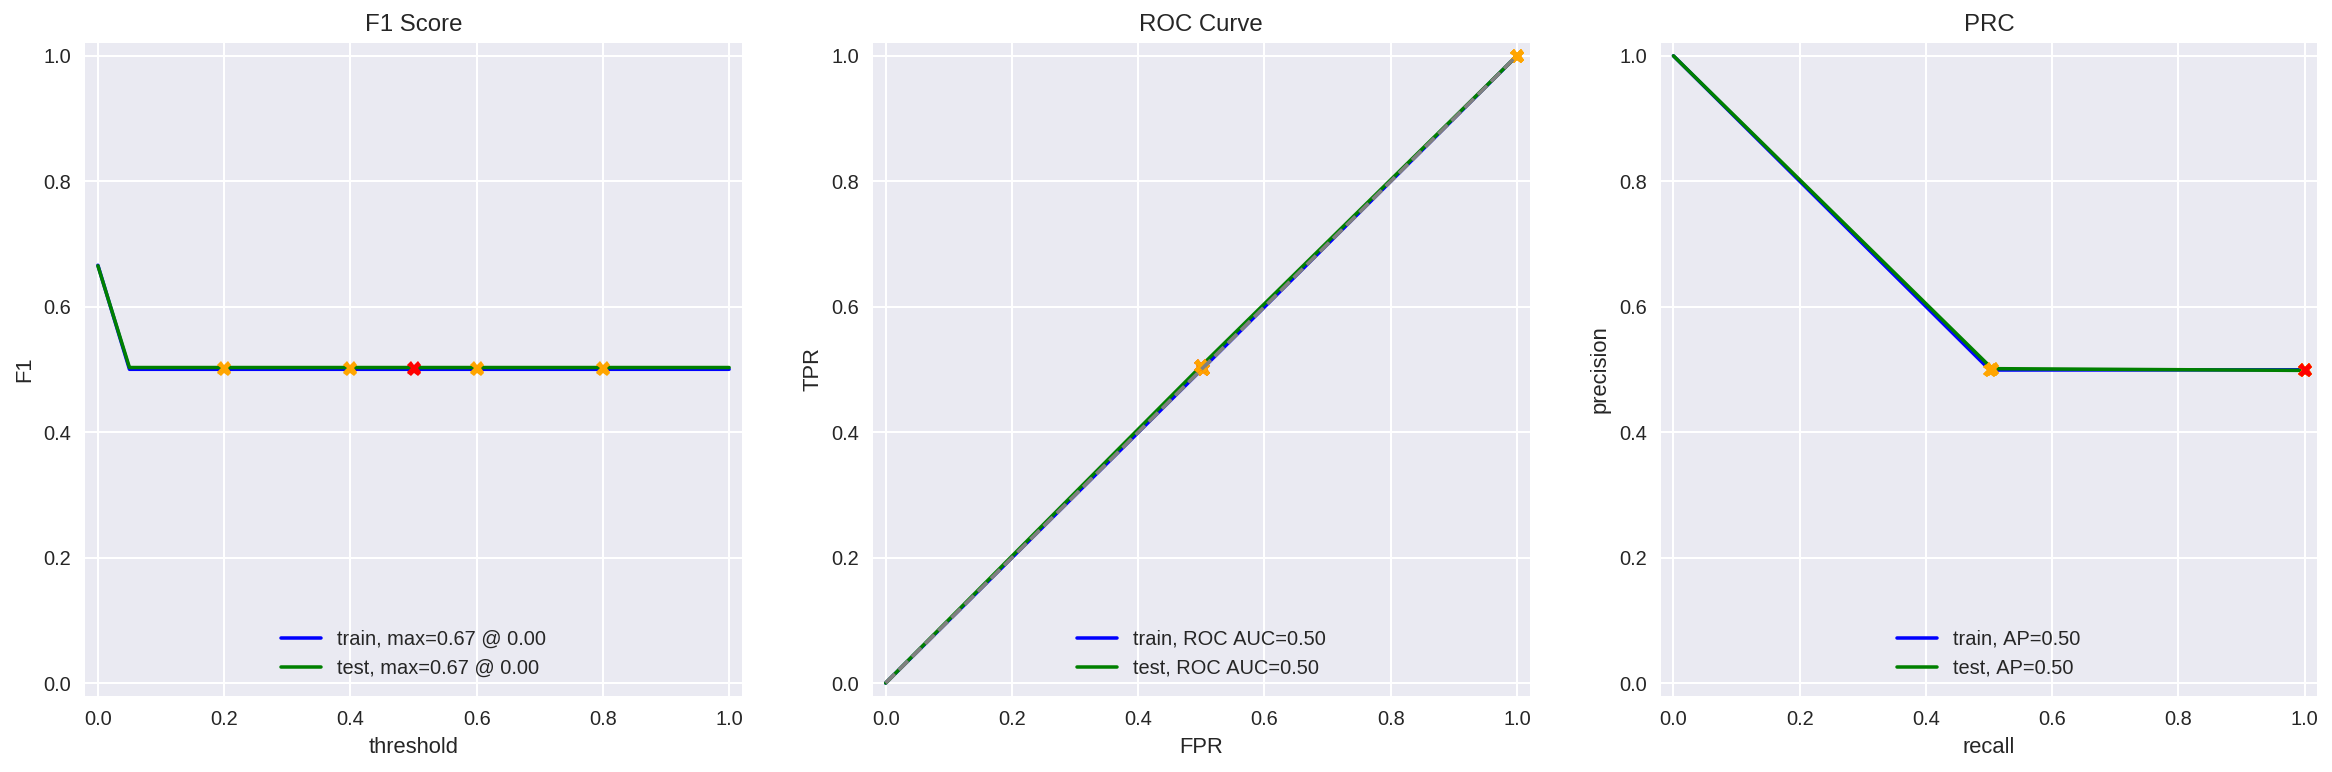

In [26]:
evaluate_model(clf_dummy, train_features_1, train_target, test_features_1, test_target)

> The F1-score is a measure of a model's accuracy on a dataset. The DummyClassifier has an accuracy of .50 meaning it has an even number of false positives and negatives. It's not perfect, but the model does not fail either. 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [27]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(train_features_1, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


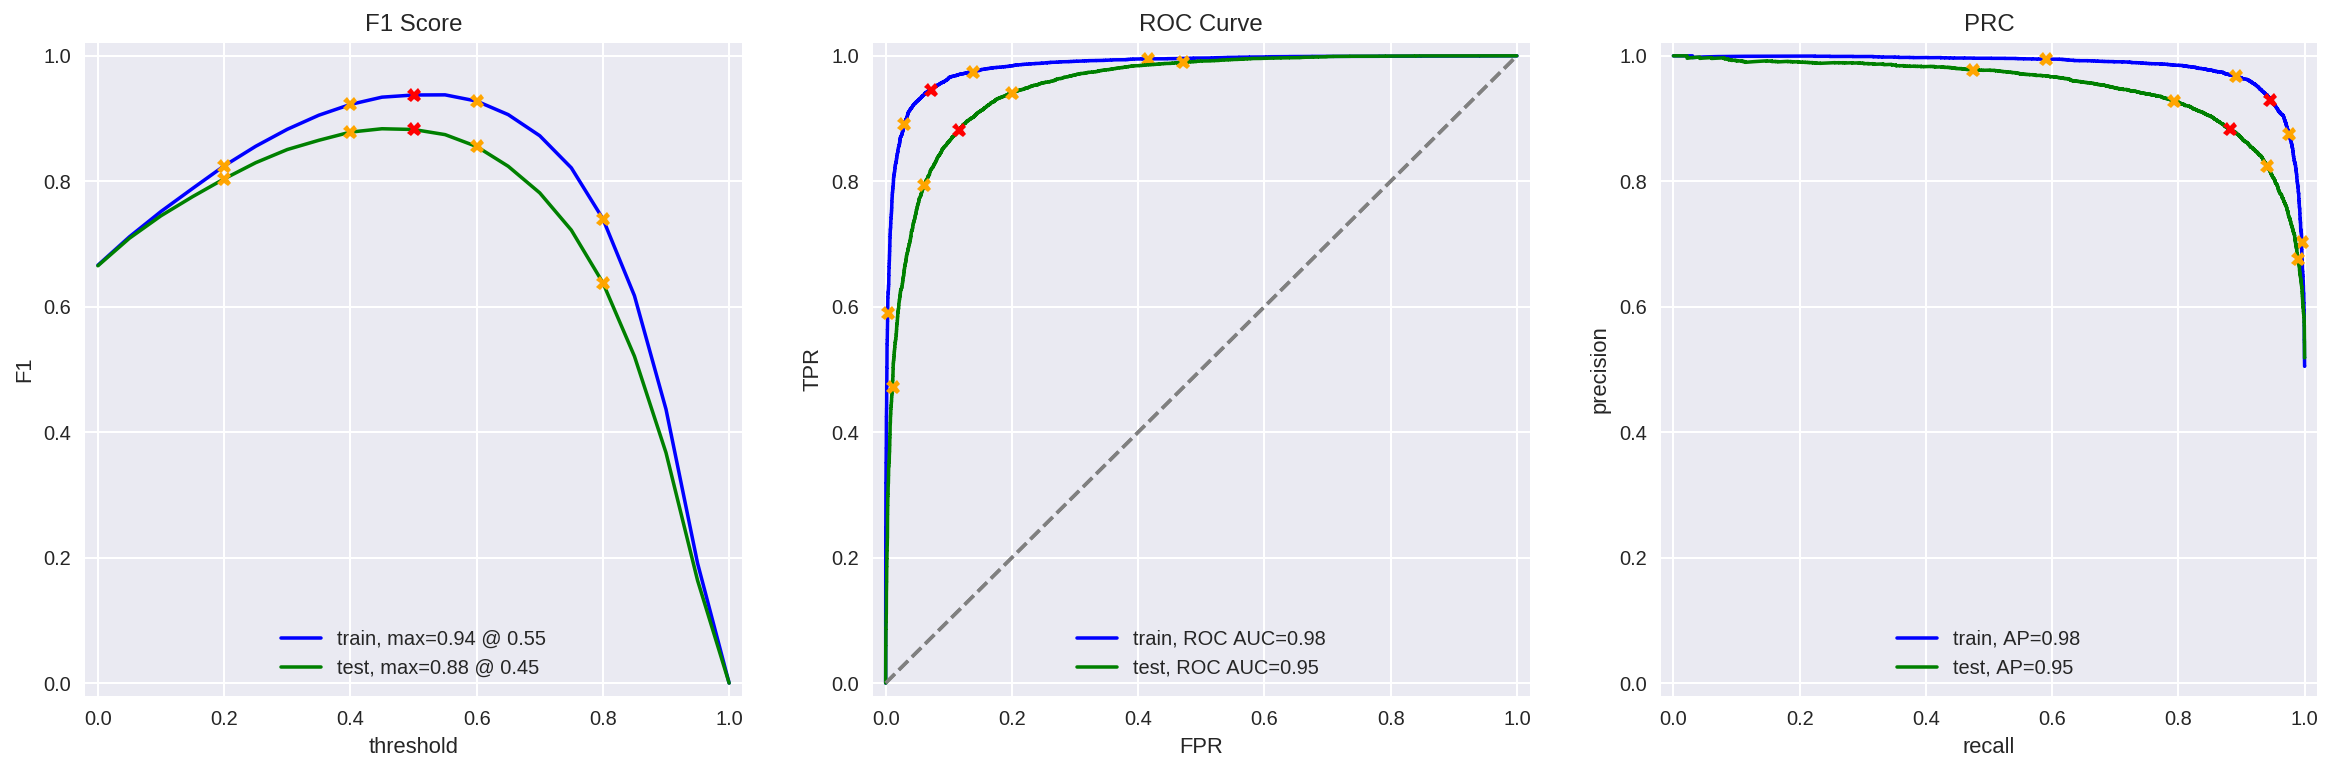

In [28]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

> This model has a high accuracy and therefore can give a confident answer of whether a review is positive or not!

### Model 3 - spaCy, TF-IDF and LR

In [29]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [31]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [32]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [33]:
X = df_reviews_train['review'] # the features we want to analyze
ylabels = df_reviews_train['pos'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [34]:
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7feaec65b5d0>),
                ('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_wor...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7feaec3cf9e0>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                      

          train  test
Accuracy   0.94  0.89
F1         0.94  0.89
APS        0.98  0.96
ROC AUC    0.98  0.96


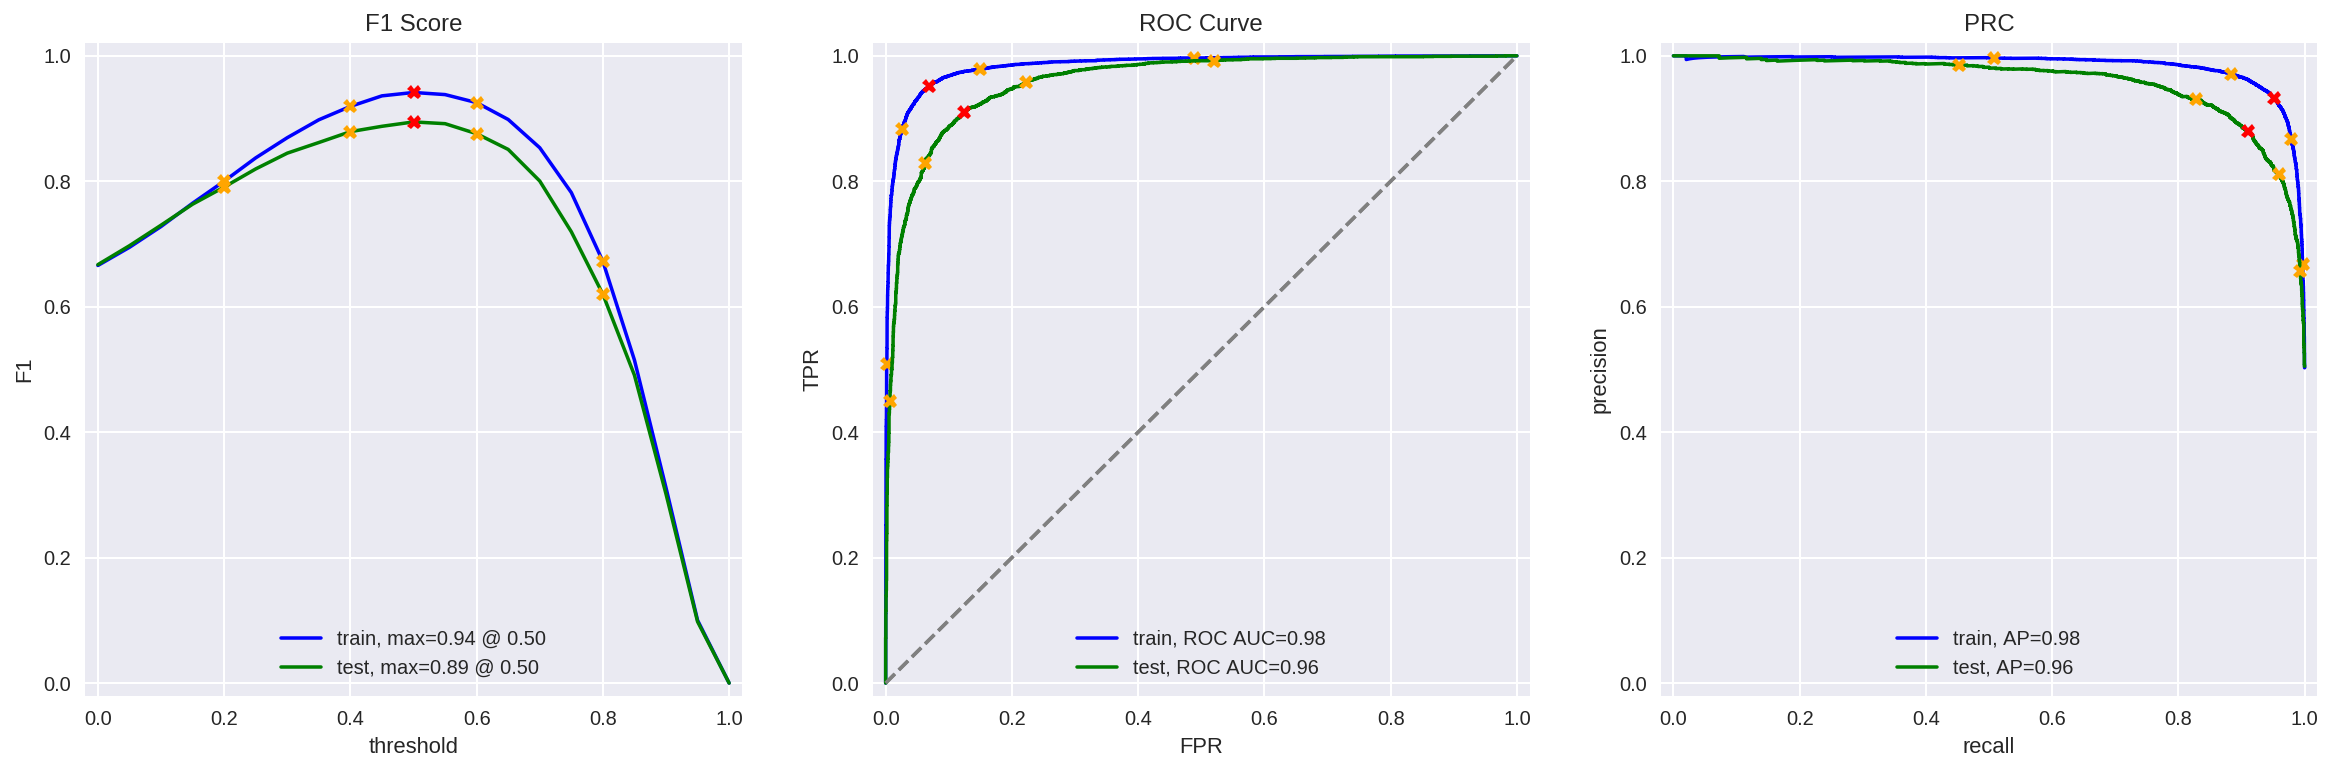

In [35]:
evaluate_model(pipe, X_train, y_train, X_test, y_test)

> As far as the F1 score goes, it is the same as the NLTK model. The AUC ROC score tells how much the model is capable of distinguishing between classes. The model had a better training AUC ROC score but had the same test score as the NLTK model. The test set,however, is the same. 

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [36]:
# lgbmodel = lgb.train(params,
#                     train_set = d_train, num_boost_round=1, early_stopping_rounds = 25)

In [37]:
#1.train_test_split
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

In [38]:
#2.tf-idf
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)
train_features_2 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])
train_features_2[0,:].toarray().shape

(1, 71531)

In [39]:
#3.train the model

hyper_params = {'objective' : 'regression',
                'boosting_type': 'gbdt',
                'learning_rate': 0.6,
                 'max_depth': 10,
                 'num_leaves': 20,
                 'metric' : 'rmse',
                 'feature_fraction': 0.8, 
                 'bagging_fraction': 0.7,
                 'bagging_freq': 10,
                 'verbose': 0}

In [40]:
clf = lgbm.LGBMClassifier()
train_data = lgbm.Dataset(train_features_2, label = train_target)
test_data = lgbm.Dataset(test_features_2, label = test_target)

In [41]:
clf.fit(train_features_2, train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


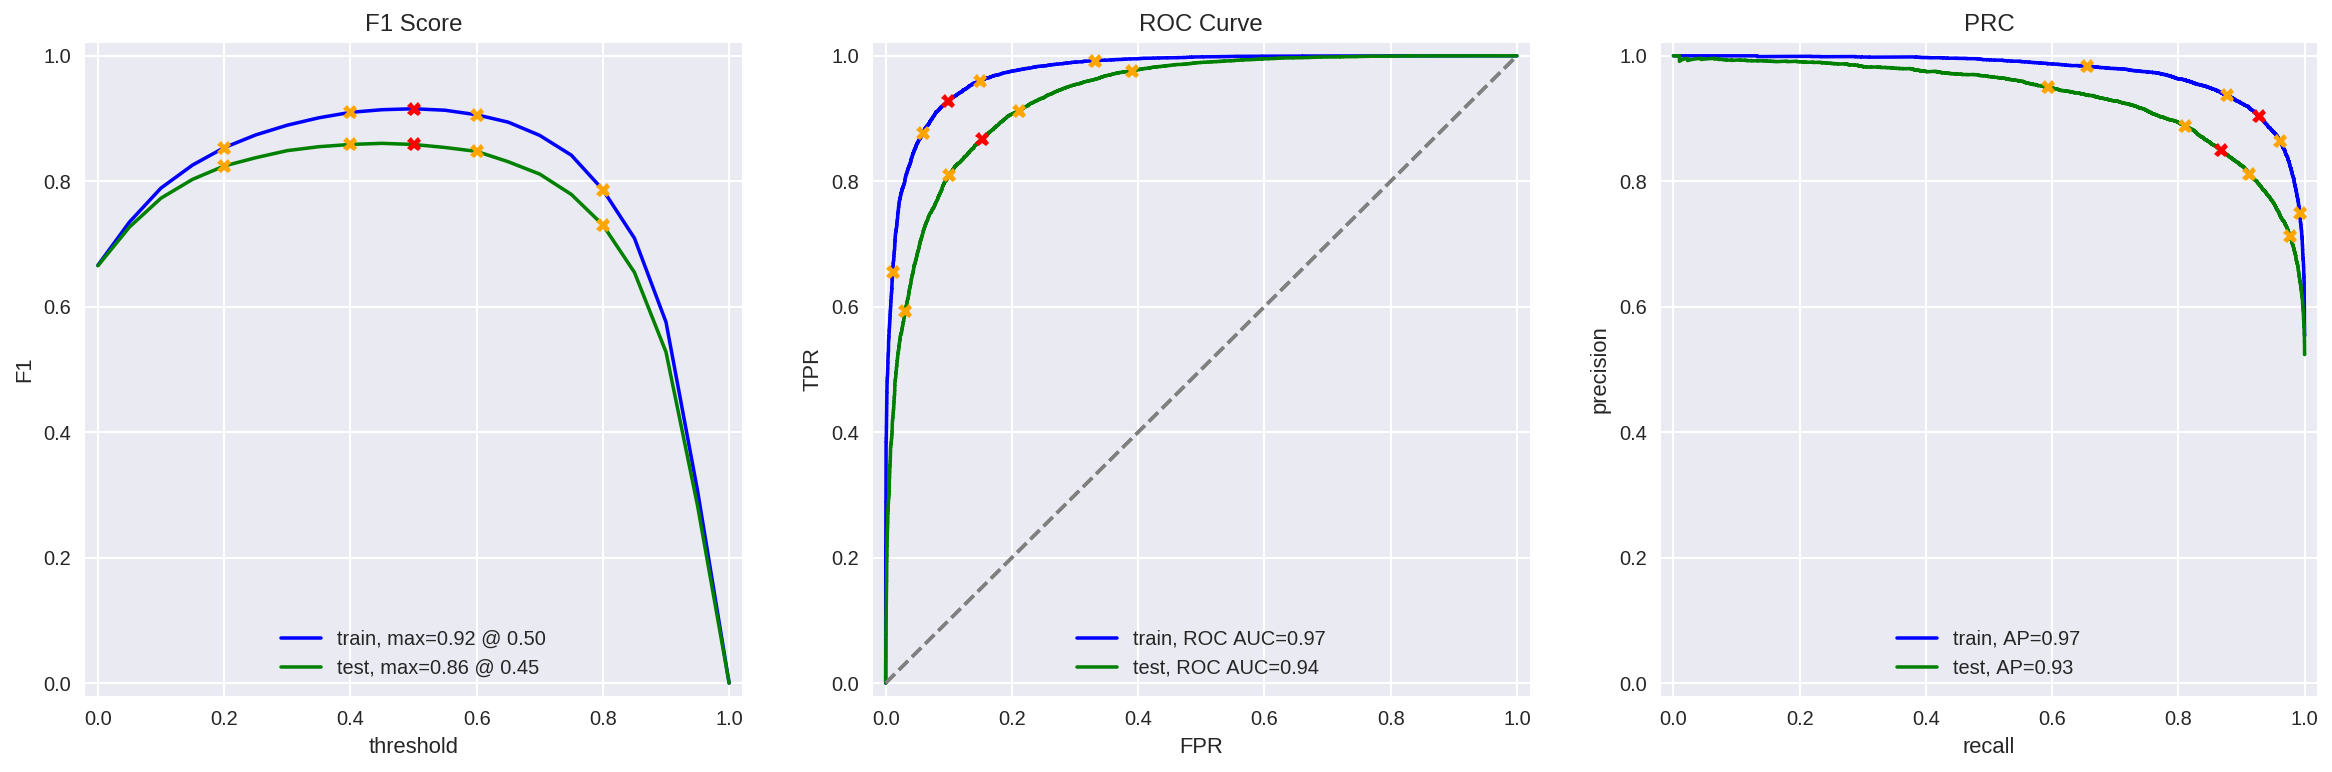

In [42]:
#4. Evaluate model
evaluate_model(clf, train_features_2, train_target, test_features_2, test_target)

This model performs worse than the NLTK and Spacy - LR model. Since there are better options, it would not be wise for the Film Junky Union to use this. 

###  Model 9 - BERT

In [43]:
import torch
import transformers

In [44]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [45]:
df_reviews_test['review_norm'].iloc[:2]

2    there is no real story the film seems more lik...
3    um      a serious film about troubled teens in...
Name: review_norm, dtype: object

In [46]:
ids_list = df_reviews_test['review_norm'].iloc[:2].apply(lambda x: tokenizer.encode(x.lower(), add_special_tokens=True, truncation=True, max_length=512))

In [47]:
(ids_list.iloc[0])

[101,
 2045,
 2003,
 2053,
 2613,
 2466,
 1996,
 2143,
 3849,
 2062,
 2066,
 1037,
 4875,
 2006,
 1996,
 2813,
 3689,
 4516,
 2084,
 1037,
 5372,
 2143,
 2061,
 2023,
 3538,
 2089,
 1999,
 2993,
 2022,
 1037,
 27594,
 2121,
 9458,
 3689,
 2055,
 2402,
 5264,
 2319,
 4268,
 2200,
 2714,
 2000,
 2866,
 15775,
 15088,
 2040,
 2377,
 19817,
 13860,
 2102,
 2013,
 2082,
 2448,
 2007,
 18542,
 2131,
 2046,
 9590,
 15301,
 2111,
 2006,
 1996,
 2395,
 2131,
 18395,
 6865,
 2055,
 2725,
 2498,
 4385,
 4385,
 2027,
 3227,
 5674,
 3209,
 2000,
 2022,
 2524,
 1998,
 2296,
 2061,
 2411,
 11245,
 10368,
 9680,
 29534,
 2046,
 1996,
 4950,
 6361,
 1999,
 8692,
 2806,
 3435,
 7659,
 4689,
 4950,
 12113,
 4389,
 2485,
 11139,
 1998,
 7284,
 25347,
 2015,
 1996,
 7982,
 2453,
 2031,
 2042,
 15594,
 2121,
 1999,
 1996,
 2434,
 4155,
 1997,
 15831,
 1998,
 7570,
 24103,
 2368,
 2084,
 1999,
 1996,
 4942,
 27430,
 1998,
 1045,
 2031,
 2053,
 4797,
 2008,
 2070,
 1997,
 1996,
 3824,
 5264,
 7604,
 2097,
 75

In [48]:
ids_list = ids_list.apply(lambda x: np.array(x[:512] + [0]*(512 - len(x))))

In [49]:
len(ids_list.iloc[0])
attention_mask_list = ids_list.apply(lambda x: np.where(x != 0, 1, 0))
attention_mask_list

2    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: review_norm, dtype: object

In [50]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')
    
    # <put your code here to create ids_list and attention_mask_list>
    ids_list = texts.apply(lambda x: tokenizer.encode(x.lower(), add_special_tokens=True, truncation=True, max_length=max_length))
    
    ids_list = ids_list.apply(lambda x: np.array(x[:max_length] + [0]*(max_length - len(x))))
    attention_mask_list = ids_list.apply(lambda x: np.where(x != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [51]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [52]:
# train_features_9.shape

In [53]:
# test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'].iloc[:15], batch_size=10, force_device='cuda')

In [54]:
# word2vec

In [55]:
# fasttext

In [56]:
# model_9 = LogisticRegression(random_state=12345, solver='liblinear')
# model_9.fit(train_features_9, train_target.iloc[:30])

In [57]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [58]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [59]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub(r"[^a-zA-Z']", ' ', x.lower()))
# <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


### Model 1 - NLTK, tf-idf, Logistic Regression

In [60]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn't expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 2 - Spacy, tf-idf, Logistic Regression

In [61]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = classifier.predict_proba(tfidf_vector.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it  not my kind of movie 
0.11:  well  i was bored and felt asleep in the middle of the movie 
0.52:  i was really fascinated with the movie
0.21:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.33:  i didn't expect the reboot to be so good  writers really cared about the source material
0.39:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.85:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 3 - Spacy, tf-idf, Lightgbm

In [62]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_2
my_reviews_pred_prob = clf.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it  not my kind of movie 
0.49:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.36:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.58:  i didn't expect the reboot to be so good  writers really cared about the source material
0.63:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.20:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.64:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 9

In [63]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

> Given an equally balanced dataset, three models were created and trained to automatically detect negative movie reviews. When preprocessing the data, no anomalies were found; while only 1% of the data was missing, dropping it would prove no big impact on the dataset moving forward. While all of the models had f1 scores above 85, the second model using Spacy, TF-IDF, and Logistic Regression provided the highest F1 score and thus has the most accuracy. This is even noticed when reviews are run through the model and positive and negative reviews are labeled correctly. The Film Junky Union wanted a model that would assist in filtering and categorizing these reviews and I believe Model 2 would do just that. 